In [101]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [102]:
def plot_cm(labels, predictions, target_names=None):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix for multi classification model')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    print(classification_report(labels, predictions, target_names=target_names))

In [75]:
def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    
    num_epochs = len(history.epoch)
    epochs = [x+1 for x in history.epoch]
    
    ax1.plot(epochs, history.history["loss"], marker='.', label="train_loss")
    ax1.plot(epochs, history.history["val_loss"], marker='.', label="val_loss")
    ax1.set_ylabel("Loss")
    ax1.set_title("Train and Validation Loss Over Epochs", fontsize=14)
    ax1.set_xticks(epochs[0::int(num_epochs/5)], epochs[0::int(num_epochs/5)])
    ax1.set_xlabel("Epochs")
    ax1.legend()
    ax1.grid()
    
    ax2.plot(epochs, history.history["accuracy"], marker='.', label="train_accuracy")
    ax2.plot(epochs, history.history["val_accuracy"], marker='.', label="val_accuracy")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Train and Validation Accuracy Over Epochs", fontsize=14)
    ax2.set_xticks(epochs[0::int(num_epochs/5)], epochs[0::int(num_epochs/5)])
    ax2.set_xlabel("Epochs")
    ax2.legend()
    ax2.grid()
    
    plt.show()
    
    return

In [71]:
def category_extraction(df):    
    # extract attack category from label
    category_dict = {
        'DDoS-ACK_Fragmentation' : 'DDoS',
        'DDoS-HTTP_Flood' : 'DDoS',
        'DDoS-ICMP_Flood': 'DDoS',
        'DDoS-PSHACK_Flood': 'DDoS',
        'DDoS-RSTFINFlood': 'DDoS',
        'DDoS-SYN_Flood': 'DDoS',
        'DDoS-SlowLoris': 'DDoS',
        'DDoS-SynonymousIP_Flood': 'DDoS',
        'DDoS-TCP_Flood': 'DDoS',
        'DDoS-UDP_Flood': 'DDoS',
        'DDoS-UDP_Fragmentation': 'DDoS',
        'DDoS-ICMP_Fragmentation' : 'DDoS',

        'DoS-HTTP_Flood' : 'DoS',
        'DoS-SYN_Flood' : 'DoS',
        'DoS-TCP_Flood' : 'DoS',
        'DoS-UDP_Flood' : 'DoS',

        'DictionaryBruteForce' : 'BruteForce',

        'MITM-ArpSpoofing' : 'Spoofing',
        'DNS_Spoofing' : 'Spoofing',

        'Recon-HostDiscovery' : 'Recon',
        'Recon-OSScan' : 'Recon',
        'Recon-PingSweep' : 'Recon',
        'Recon-PortScan' : 'Recon',
        'VulnerabilityScan' : 'Recon',

        'SqlInjection' : 'Web-based',
        'CommandInjection' : 'Web-based',
        'Backdoor_Malware' : 'Web-based',
        'Uploading_Attack' : 'Web-based',
        'XSS' : 'Web-based',
        'BrowserHijacking' : 'Web-based',

        'Mirai-greeth_flood' : 'Mirai',
        'Mirai-greip_flood' : 'Mirai',
        'Mirai-udpplain' : 'Mirai',

        'BenignTraffic' : 'Benign'
    }

    # label encoding for attack categories
    df_label_cat = df.label.apply(lambda x: category_dict.get(x))
    df['label'] = df_label_cat
    return df

In [72]:
def csvToBalancedDataset(first, last):
    balanced_dfs = []
    for index in range(first,last):
        try:
            df = pd.read_csv(f"/kaggle/input/cic-iot-2023/part-{str(index).zfill(5)}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv")
        except Exception:
            print("index out of range")
        # change column names
        df.columns = ['_'.join(c.split(' ')).lower() for c in df.columns]
        
        # drop NULLs & reset index
        entries_before = len(df)
        df.dropna(inplace=True)
        df.reset_index(inplace=True, drop=True)
        # extract binary labels
        df = category_extraction(df)
        # balance the classes in each dataframe
        # TO DO
        balanced_dfs.append(df)
    
    return pd.concat(balanced_dfs, axis=0, ignore_index=True)

In [7]:
df = csvToBalancedDataset(0,50)
df['label'].value_counts()

label
DDoS          9361472
DoS           2227900
Mirai          725551
Benign         302896
Spoofing       134176
Recon           97110
Web-based        6850
BruteForce       3590
Name: count, dtype: int64

In [9]:
# Saving the objects:
with open('objs.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(df, f)

In [49]:
# Getting back the objects:
with open('objs.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    df = pickle.load(f)

In [50]:
y = df['label']
x = df.drop('label', axis=1)

In [51]:
from imblearn.under_sampling import RandomUnderSampler

dic = {'DDoS':10000, 'DoS':10000, 'Mirai':10000, 'Benign':10000, 'Spoofing':10000, 'Recon':10000}
ros = RandomUnderSampler(random_state=42, sampling_strategy=dic)
x, y = ros.fit_resample(x, y)

In [52]:
from imblearn.over_sampling import RandomOverSampler

dic = {'Web-based':10000, 'BruteForce':10000}
ros = RandomOverSampler(random_state=42, sampling_strategy=dic)
x, y = ros.fit_resample(x, y)



In [54]:
y.value_counts()

label
Benign        10000
BruteForce    10000
DDoS          10000
DoS           10000
Mirai         10000
Recon         10000
Spoofing      10000
Web-based     10000
Name: count, dtype: int64

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [56]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

In [57]:
# Spliting data 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [58]:
print("Data type: {}".format(x_train.dtype))
print("Range: [{}, {}]".format(np.min(x_train), np.max(x_train)))
print("(Height, Width): {}".format(x_train[0].shape))

Data type: float64
Range: [0.0, 1.0]
(Height, Width): (46,)


In [59]:
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(lambda x, y: (x, y), num_parallel_calls=AUTO).shuffle(train_ds.cardinality()).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(lambda x, y: (x, y), num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(lambda x, y: (x, y), num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

In [107]:
import tensorflow as tf

def create_model():
    
    model = tf.keras.models.Sequential([
            # first block
            tf.keras.layers.Conv1D(filters=64, kernel_size=(3), name="conv1", padding='same'),
            tf.keras.layers.Activation(activation="relu", name="act_conv1"),
            tf.keras.layers.MaxPooling1D(pool_size=(2), name="pool1"),
            # second block
            tf.keras.layers.Conv1D(filters=128, kernel_size=(3), name="conv2", padding='same'),
            tf.keras.layers.Activation(activation="relu", name="act_conv2"),
            tf.keras.layers.MaxPooling1D(pool_size=(2), name="pool2"),
            # third block
            tf.keras.layers.Conv1D(filters=256, kernel_size=(3), name="conv3", padding='same'),
            tf.keras.layers.Activation(activation="relu", name="act_conv3"),
            # flatten
            tf.keras.layers.Flatten(name="flatten"),
            # classifier
            tf.keras.layers.Dense(units=256, name="fc1"),
            tf.keras.layers.Activation(activation="relu", name="act_fc1"),
            tf.keras.layers.Dropout(rate=0.2, name="dropout_1"),
            tf.keras.layers.Dense(units=128, name="fc2"),
            tf.keras.layers.Activation(activation="relu", name="act_fc2"),
            tf.keras.layers.Dropout(rate=0.2, name="dropout_2"),
            tf.keras.layers.Dense(units=64, name="fc3"),
            tf.keras.layers.Activation(activation="relu", name="act_fc3"),
            tf.keras.layers.Dropout(rate=0.2, name="dropout_3"),
            tf.keras.layers.Dense(units=8, activation="softmax", name="output")
        ])
    
    model.build(input_shape=(None, 46, 1))
    return model
    
model = create_model()

In [108]:
model.summary(line_length=80)

Model: "sequential_8"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv1 (Conv1D)                     (None, 46, 64)                  256         
                                                                                
 act_conv1 (Activation)             (None, 46, 64)                  0           
                                                                                
 pool1 (MaxPooling1D)               (None, 23, 64)                  0           
                                                                                
 conv2 (Conv1D)                     (None, 23, 128)                 24704       
                                                                                
 act_conv2 (Activation)             (None, 23, 128)                 0           
                                                                                
 pool2

In [109]:
model.compile(
    optimizer=tf.optimizers.Adam(0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    ]
)

In [110]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=140,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/140
800/800 [==============================] - 23s 25ms/step - loss: 1.0418 - accuracy: 0.5405 - val_loss: 0.9012 - val_accuracy: 0.6132
Epoch 2/140
800/800 [==============================] - 20s 25ms/step - loss: 0.9104 - accuracy: 0.6013 - val_loss: 0.8881 - val_accuracy: 0.6158
Epoch 3/140
800/800 [==============================] - 20s 25ms/step - loss: 0.8942 - accuracy: 0.6113 - val_loss: 0.8823 - val_accuracy: 0.6209
Epoch 4/140
800/800 [==============================] - 20s 25ms/step - loss: 0.8804 - accuracy: 0.6206 - val_loss: 0.8345 - val_accuracy: 0.6481
Epoch 5/140
800/800 [==============================] - 20s 25ms/step - loss: 0.8875 - accuracy: 0.6222 - val_loss: 0.8819 - val_accuracy: 0.6379
Epoch 6/140
800/800 [==============================] - 20s 25ms/step - loss: 0.8741 - accuracy: 0.6294 - val_loss: 0.8497 - val_accuracy: 0.6419
Epoch 7/140
800/800 [==============================] - 20s 25ms/step - loss: 0.8801 - accuracy: 0.6265 - val_loss: 0.8246 - val_ac

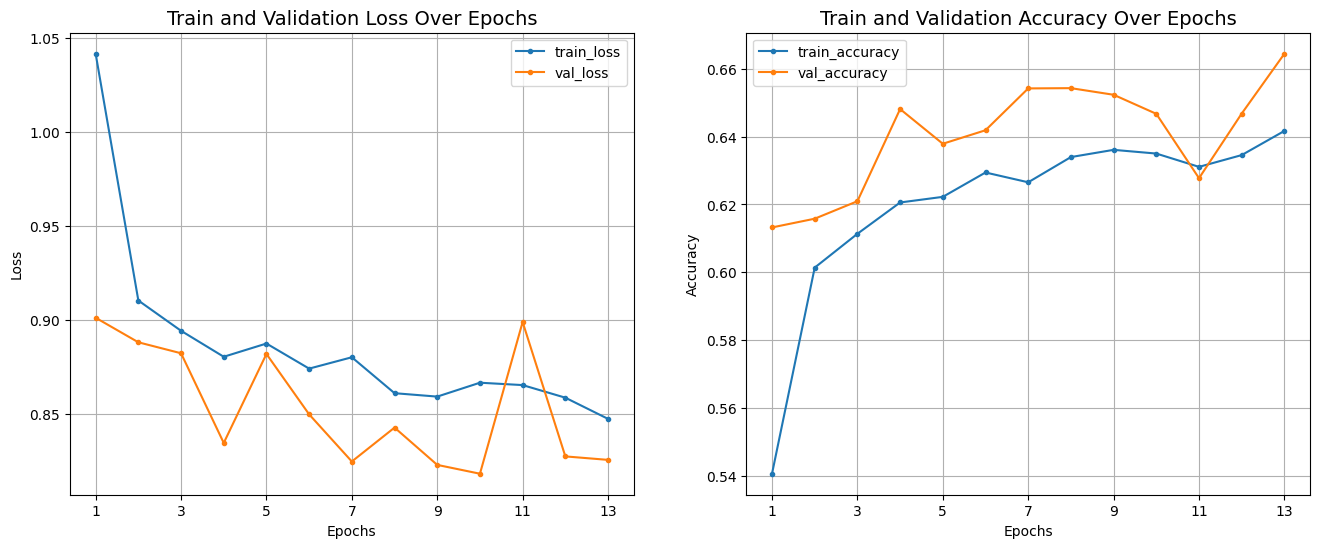

In [111]:
plot_history(history)

In [115]:
test_labels = np.concatenate([labels.numpy() for _, labels in test_ds])

In [116]:
predictions = model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

250/250 [==============================] - 2s 8ms/step


              precision    recall  f1-score   support

      Benign       0.57      0.70      0.63      1973
  BruteForce       0.57      0.33      0.41      2030
        DDoS       0.72      0.73      0.73      1920
         DoS       0.75      0.73      0.74      2063
       Mirai       1.00      0.99      1.00      2011
       Recon       0.94      0.42      0.58      1992
    Spoofing       0.82      0.53      0.64      2014
   Web-based       0.40      0.85      0.54      1997

    accuracy                           0.66     16000
   macro avg       0.72      0.66      0.66     16000
weighted avg       0.72      0.66      0.66     16000



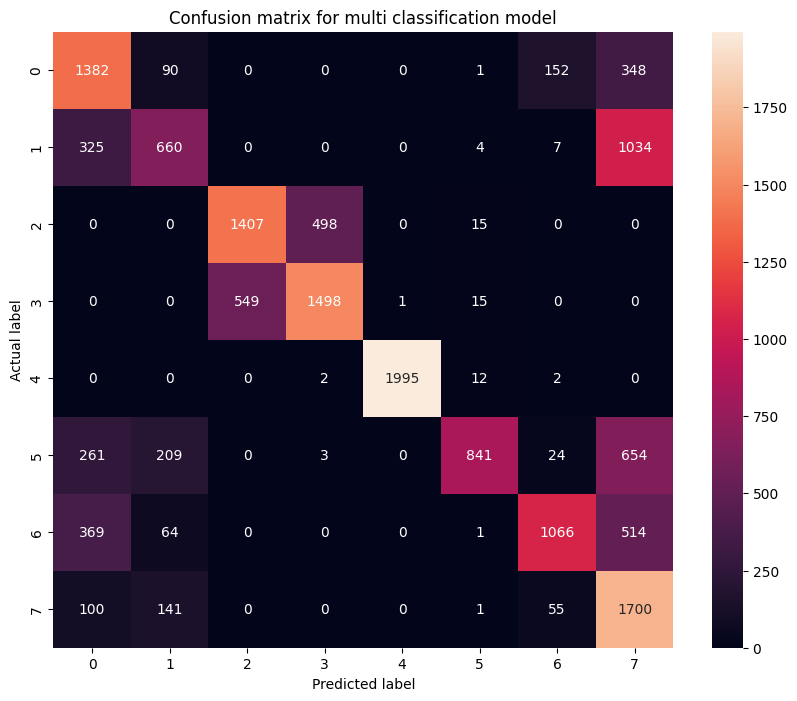

In [117]:
plot_cm(test_labels, predictions, label_encoder.classes_)

In [ ]:
accuracy = model.evaluate(test_ds)
print("Test loss: {}".format(round(loss, 4)))
print("Test  accuracy: {}%".format(round(accuracy*100, 2)))